In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import xgboost as xgb

sns.set(style="whitegrid")


In [2]:
# Optional: Encoding utilities (future use)
from sklearn.preprocessing import LabelEncoder

def label_encode(df, columns):
    encoder = LabelEncoder()
    for col in columns:
        df[col] = encoder.fit_transform(df[col])
    return df

def one_hot_encode(df, columns):
    return pd.get_dummies(df, columns=columns, drop_first=True)


In [3]:
# Load breast cancer dataset and extract 'worst' features
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Use only 'worst' features for training
worst_columns = [col for col in df.columns if 'worst' in col]
X = df[worst_columns]
y = df['target']


In [4]:
# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
# Define and train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


SVM (RBF) Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.97      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114


Decision Tree Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        43
           1       0.94      0.93      0.94        71

    accuracy                           0.92       114
   macro avg       0.91      0.92   

/home/vscode/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [08:59:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


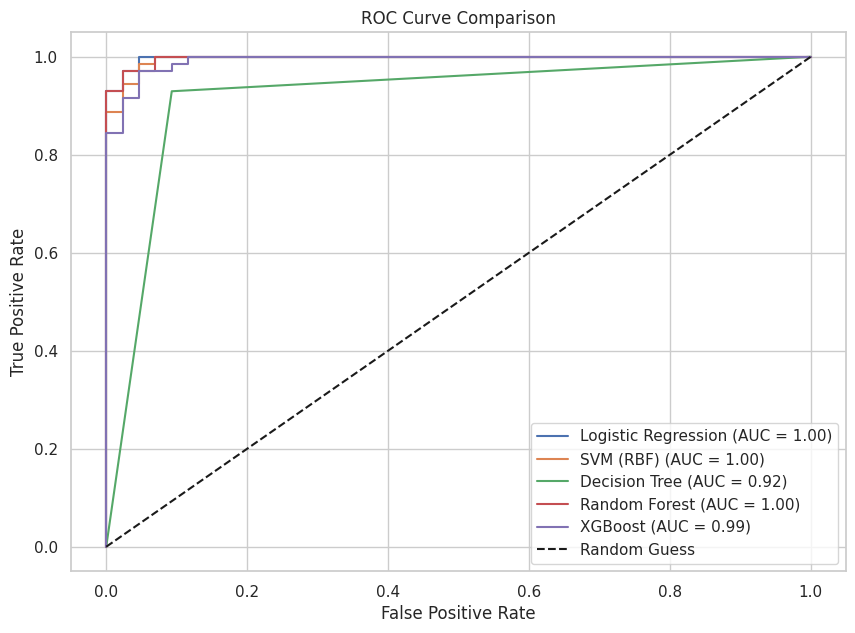

In [6]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 7))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.decision_function(X_test_scaled)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [7]:
from sklearn.model_selection import GridSearchCV

# Store best models
best_models = {}


In [8]:
# Random Forest tuning
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train_scaled, y_train)

best_models['Random Forest'] = rf_grid.best_estimator_

print("\n✅ Best RF Parameters:", rf_grid.best_params_)
print("RF Best CV Score:", rf_grid.best_score_)



✅ Best RF Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
RF Best CV Score: 0.9604395604395604


In [9]:
# SVM tuning
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(SVC(probability=True), svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train_scaled, y_train)

best_models['SVM'] = svm_grid.best_estimator_

print("\n✅ Best SVM Parameters:", svm_grid.best_params_)
print("SVM Best CV Score:", svm_grid.best_score_)



✅ Best SVM Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Best CV Score: 0.9714285714285713


In [10]:

# XGBoost tuning
xgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    xgb_params,
    cv=5,
    scoring='accuracy'
)
xgb_grid.fit(X_train_scaled, y_train)

best_models['XGBoost'] = xgb_grid.best_estimator_

print("\n✅ Best XGBoost Parameters:", xgb_grid.best_params_)
print("XGBoost Best CV Score:", xgb_grid.best_score_)


/home/vscode/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:03:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:03:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:03:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:03:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.13/site-packages/xgboost/trainin


✅ Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost Best CV Score: 0.956043956043956


In [11]:
import shap
shap.initjs()


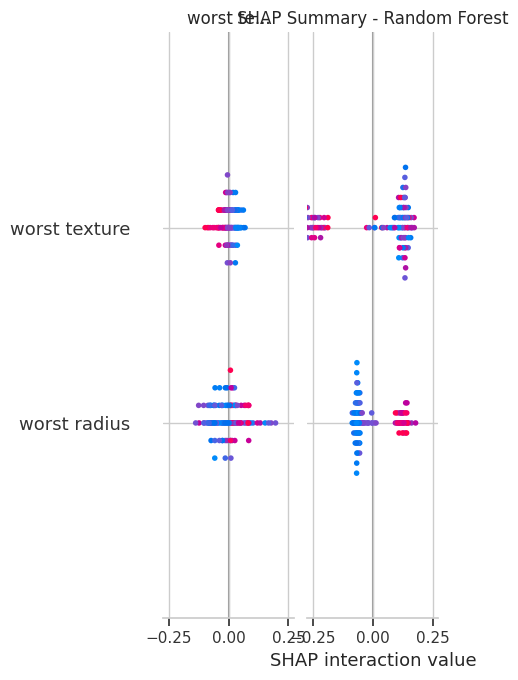

In [12]:
# SHAP for Random Forest
rf_model = best_models['Random Forest']
rf_model.fit(X_train_scaled, y_train)

explainer_rf = shap.Explainer(rf_model, X_train_scaled)
shap_values_rf = explainer_rf(X_test_scaled)

shap.summary_plot(
    shap_values_rf,
    features=X_test,
    feature_names=X.columns,
    show=False
)
plt.title('SHAP Summary - Random Forest')
plt.show()


/home/vscode/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:06:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


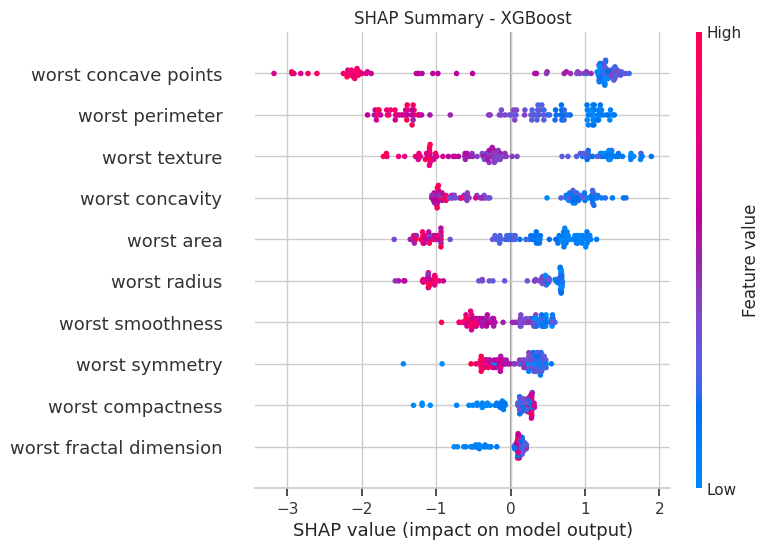

In [13]:
# SHAP for XGBoost
xgb_model = best_models['XGBoost']
xgb_model.fit(X_train_scaled, y_train)

explainer_xgb = shap.Explainer(xgb_model, X_train_scaled)
shap_values_xgb = explainer_xgb(X_test_scaled)

shap.summary_plot(
    shap_values_xgb,
    features=X_test,
    feature_names=X.columns,
    show=False
)
plt.title('SHAP Summary - XGBoost')
plt.show()


In [19]:
# svm_model = best_models['SVM']
# svm_model.fit(X_train_scaled, y_train)

# # Sample background and explanation set
# background = shap.sample(X_train_scaled, 100)
# X_test_sample = X_test_scaled[:50]

# # KernelExplainer and SHAP values
# explainer_svm = shap.KernelExplainer(svm_model.predict_proba, background)
# shap_values_svm = explainer_svm.shap_values(X_test_sample, nsamples=100)

# # Convert input sample back to DataFrame for plotting
# X_test_df = pd.DataFrame(X_test_sample, columns=X.columns)

# # Plot SHAP summary for class 1 (malignant)
# shap.summary_plot(
#     shap_values_svm[1],              # SHAP values for class 1
#     features=X_test_df,              # Must be DataFrame, not NumPy array
#     feature_names=X.columns
# )
